In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

EPOCHS = 200

## Read Dataset from CSV file

CSV file is modified to have columns as follows:

- sentence: original sentence
- label : class (0 to 4)
- tokens : tokenized sentence
- score : sentiment score (0 to 1)


In [5]:
train_df = pd.read_csv("/kaggle/input/sst-dataset/train.csv")
print("Train size: ", len(train_df))

val_df = pd.read_csv("/kaggle/input/sst-dataset/val.csv")
print("Val size  : ", len(val_df))

test_df = pd.read_csv("/kaggle/input/sst-dataset/test.csv")
print("Test size : ", len(test_df))

Train size:  8544
Val size  :  1101
Test size :  2210


## Classes Distribution


Train class distribution:
label
0    1092
1    2218
2    1624
3    2322
4    1288
Name: count, dtype: int64
Val class distribution:
label
0    139
1    289
2    229
3    279
4    165
Name: count, dtype: int64
Test class distribution:
label
0    279
1    633
2    389
3    510
4    399
Name: count, dtype: int64


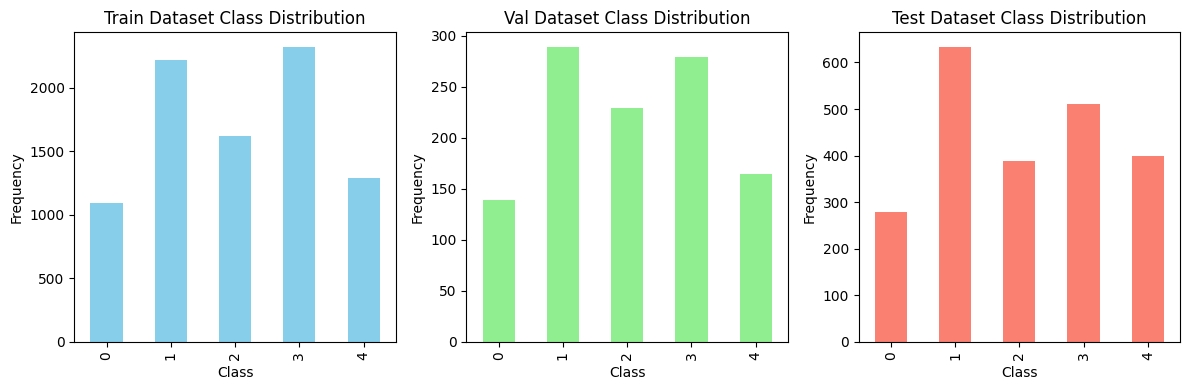

In [6]:
print("Train class distribution:")
print(train_df.label.value_counts().sort_index())

print("Val class distribution:")
print(val_df.label.value_counts().sort_index())

print("Test class distribution:")
print(test_df.label.value_counts().sort_index())

plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
train_df["label"].value_counts().sort_index().plot(kind="bar", color="skyblue")
plt.title("Train Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.subplot(1, 3, 2)
val_df["label"].value_counts().sort_index().plot(kind="bar", color="lightgreen")
plt.title("Val Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.subplot(1, 3, 3)
test_df["label"].value_counts().sort_index().plot(kind="bar", color="salmon")
plt.title("Test Dataset Class Distribution")
plt.xlabel("Class")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

## Tokenization


In [7]:
def tokenize(tokens):
    return tokens.lower().split()

In [8]:
print("Sentence:")
print(train_df.iloc[3]["sentence"])

print("\nSentence Tokenized:")
tokens = tokenize(train_df.iloc[3]["sentence"])
print(tokens)

Sentence:
You 'd think by now America would have had enough of plucky British eccentrics with hearts of gold .

Sentence Tokenized:
['you', "'d", 'think', 'by', 'now', 'america', 'would', 'have', 'had', 'enough', 'of', 'plucky', 'british', 'eccentrics', 'with', 'hearts', 'of', 'gold', '.']


## Bigrams


In [9]:
def extract_bigrams(sentence):
    words = tokenize(sentence)
    return [(words[i], words[i + 1]) for i in range(len(words) - 1)]

## Feature Matrix for Train dataset

using int8 instead of float64 to save memory


In [10]:
def generate_train_features(dataframe):
    unique_bigrams = set()
    for _, sample in dataframe.iterrows():
        sample_bigrams = extract_bigrams(sample["sentence"])
        unique_bigrams.update(sample_bigrams)

    bigrams_indices = {bi_gram: index for index, bi_gram in enumerate(unique_bigrams)}

    feature_matrix = np.zeros((len(dataframe), len(unique_bigrams)))

    for i, (_, sample) in enumerate(dataframe.iterrows()):
        sample_bigrams = extract_bigrams(sample["sentence"])
        for b in sample_bigrams:
            index = bigrams_indices.get(b)
            if index is not None:
                feature_matrix[i, index] = 1

    return feature_matrix, bigrams_indices

In [11]:
train_feature_matrix, train_bigrams_indices = generate_train_features(train_df)
print(
    "Train Feature matrix shape (samples x unique bigrams):", train_feature_matrix.shape
)
print("Train Feature matrix datatype:", train_feature_matrix.dtype)

Train Feature matrix shape (samples x unique bigrams): (8544, 84518)
Train Feature matrix datatype: float64


## Unify features for val & test set

Remove all Features (bigrams) from val & test set that doesn't appear in training features


In [12]:
def filter_features(dataframe):
    unique_dataframe_bigrams = set()
    for _, sample in dataframe.iterrows():
        sample_bigrams = extract_bigrams(sample["sentence"])
        unique_dataframe_bigrams.update(sample_bigrams)

    unique_train_bigrams = set(train_bigrams_indices.keys())
    common_bigrams = unique_dataframe_bigrams.intersection(unique_train_bigrams)
    feature_matrix = np.zeros((len(dataframe), len(train_bigrams_indices)))

    for i, (_, sample) in enumerate(dataframe.iterrows()):
        sample_bigrams = extract_bigrams(sample["sentence"])
        for b in sample_bigrams:
            if b in common_bigrams:
                index = train_bigrams_indices.get(b)
                feature_matrix[i, index] = 1

    return feature_matrix

In [13]:
val_feature_matrix = filter_features(val_df)
print("Val Feature matrix shape (samples x unique bigrams):", val_feature_matrix.shape)

test_feature_matrix = filter_features(test_df)
print(
    "\nTest Feature matrix shape (samples x unique bigrams):",
    test_feature_matrix.shape,
)

Val Feature matrix shape (samples x unique bigrams): (1101, 84518)

Test Feature matrix shape (samples x unique bigrams): (2210, 84518)


## Model Implementation


In [14]:
X_train = train_feature_matrix
y_train = train_df.label.values

X_val = val_feature_matrix
y_val = val_df.label.values

X_test = test_feature_matrix
y_test = test_df.label.values

### Training & Validation


In [15]:
def softmax(x):
    exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_x / np.sum(exp_x, axis=1, keepdims=True)


class LR:
    def __init__(self, num_classes=5, epochs=100, learning_rate=1):
        self.num_classes = num_classes
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.weights = None
        self.bias = None

    def fit(self, X_train, y_train, X_val=None, y_val=None):
        n_samples, n_features = X_train.shape
        n_classes = self.num_classes

        self.weights = np.zeros((n_features, n_classes))
        self.bias = np.zeros(n_classes)

        for epoch in range(self.epochs):
            print(f"Epoch {epoch + 1}/{self.epochs}")

            permutation = np.random.permutation(n_samples)
            X_train = X_train[permutation]
            y_train = y_train[permutation]
            
            logits = X_train @ self.weights + self.bias
            probabilities = softmax(logits)

            output_hot_encoded = np.eye(n_classes)[y_train]

            error = probabilities - output_hot_encoded

            train_loss = (
                -np.sum(output_hot_encoded * np.log(probabilities + 1e-15)) / n_samples
            )

            train_preds = np.argmax(probabilities, axis=1)
            
            train_accuracy = np.mean(train_preds == y_train)
            print("Train Accuracy: ", train_accuracy)

            dw = (1 / n_samples) * np.dot(X_train.T, error)
            db = (1 / n_samples) * np.sum(error, axis=0)

            self.weights -= self.learning_rate * dw
            self.bias -= self.learning_rate * db

            if X_val is not None and y_val is not None:
                val_logits = X_val @ self.weights + self.bias
                val_probabilities = softmax(val_logits)
                val_output_hot_encoded = np.eye(n_classes)[y_val]

                val_loss = (
                    -np.sum(val_output_hot_encoded * np.log(val_probabilities + 1e-15))
                    / X_val.shape[0]
                )
                val_preds = np.argmax(val_probabilities, axis=1)
                val_accuracy = np.mean(val_preds == y_val)
                print("Val Accuracy: ", val_accuracy)

        print("*" * 20)
        print("Training Completed")
        print("Train loss: ", train_loss)
        print("Train accuracy: ", train_accuracy)
        if X_val is not None and y_val is not None:
            print("Val loss: ", val_loss)
            print("Val accuracy: ", val_accuracy)

    def predict(self, X):
        scores = np.dot(X, self.weights) + self.bias
        probabilities = softmax(scores)
        preds = np.argmax(probabilities, axis=1)
        return preds

    def save_weights(self, weights_path, bias_path):
        np.save(weights_path, self.weights)
        np.save(bias_path, self.bias)

    def load_weights(self, weights_path, bias_path):
        self.weights = np.load(weights_path)
        self.bias = np.load(bias_path)

In [16]:
model = LR(epochs=EPOCHS, learning_rate=1)
model.fit(X_train, y_train, X_val, y_val)

Epoch 1/200
Train Accuracy:  0.12780898876404495
Val Accuracy:  0.25340599455040874
Epoch 2/200
Train Accuracy:  0.2731741573033708
Val Accuracy:  0.254314259763851
Epoch 3/200
Train Accuracy:  0.274812734082397
Val Accuracy:  0.254314259763851
Epoch 4/200
Train Accuracy:  0.2777387640449438
Val Accuracy:  0.25522252497729336
Epoch 5/200
Train Accuracy:  0.282186329588015
Val Accuracy:  0.25703905540417804
Epoch 6/200
Train Accuracy:  0.29037921348314605
Val Accuracy:  0.2633969118982743
Epoch 7/200
Train Accuracy:  0.29810393258426965
Val Accuracy:  0.26430517711171664
Epoch 8/200
Train Accuracy:  0.3074672284644195
Val Accuracy:  0.26975476839237056
Epoch 9/200
Train Accuracy:  0.31624531835205993
Val Accuracy:  0.27883742052679383
Epoch 10/200
Train Accuracy:  0.32514044943820225
Val Accuracy:  0.27974568574023617
Epoch 11/200
Train Accuracy:  0.33766385767790263
Val Accuracy:  0.28247048138056313
Epoch 12/200
Train Accuracy:  0.3505383895131086
Val Accuracy:  0.28610354223433243
Ep

### Inference


In [17]:
y_pred = model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred)
print("Test accuracy: ", test_accuracy)

Test accuracy:  0.34524886877828054


### Classification Report


In [18]:
results = classification_report(y_test, y_pred, target_names=["0", "1", "2", "3", "4"])
print(np.unique(y_pred))
print(results)

[0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.50      0.00      0.01       279
           1       0.38      0.61      0.47       633
           2       0.09      0.01      0.02       389
           3       0.31      0.67      0.43       510
           4       0.59      0.08      0.14       399

    accuracy                           0.35      2210
   macro avg       0.37      0.27      0.21      2210
weighted avg       0.37      0.35      0.26      2210



## Scikit-learn


### Logistic Regression


In [19]:
logistic_model = LogisticRegression(max_iter=EPOCHS, tol=1e-4)

logistic_model.fit(X_train, y_train)

y_pred_LR = logistic_model.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_LR)

print("Test Accuracy : ", test_accuracy)

Test Accuracy :  0.36289592760180994


#### Classification Report


In [20]:
results = classification_report(y_test, y_pred_LR, target_names=["0", "1", "2", "3", "4"])
print(np.unique(y_pred_LR))
print(results)

[0 1 2 3 4]
              precision    recall  f1-score   support

           0       0.37      0.12      0.18       279
           1       0.42      0.52      0.46       633
           2       0.21      0.16      0.18       389
           3       0.34      0.55      0.42       510
           4       0.50      0.25      0.33       399

    accuracy                           0.36      2210
   macro avg       0.36      0.32      0.31      2210
weighted avg       0.37      0.36      0.34      2210



### Stochastic Gradient Descent


In [21]:
sgd_sklearn = SGDClassifier(
    loss="log_loss", max_iter=EPOCHS, learning_rate="constant", eta0=0.05, shuffle=True
)

sgd_sklearn.fit(X_train, y_train)

y_pred_SGD = sgd_sklearn.predict(X_test)

test_accuracy = accuracy_score(y_test, y_pred_SGD)

print("Test Accuracy : ", test_accuracy)

Test Accuracy :  0.3601809954751131


#### Classification Report


In [22]:
results = classification_report(y_test, y_pred_SGD, target_names=["0", "1", "2", "3", "4"])
print(results)

              precision    recall  f1-score   support

           0       0.35      0.09      0.14       279
           1       0.41      0.52      0.46       633
           2       0.19      0.16      0.18       389
           3       0.34      0.52      0.41       510
           4       0.49      0.29      0.36       399

    accuracy                           0.36      2210
   macro avg       0.36      0.32      0.31      2210
weighted avg       0.36      0.36      0.34      2210



## Metrics

In [24]:
def compute_confusion_matrix(true_labels, pred_labels, num_classes):
    matrix = np.zeros((num_classes, num_classes), dtype=int)
    for t, p in zip(true_labels, pred_labels):
        matrix[t][p] += 1
    return matrix


def calculate_metrics(conf_matrix):
    num_classes = conf_matrix.shape[0]
    precision = []
    recall = []
    f1_score = []

    for c in range(num_classes):
        tp = conf_matrix[c, c]
        fp = conf_matrix[:, c].sum() - tp
        fn = conf_matrix[c, :].sum() - tp

        precision_c = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall_c = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1_c = 2 * precision_c * recall_c / (precision_c + recall_c) if (precision_c + recall_c) > 0 else 0

        precision.append(precision_c)
        recall.append(recall_c)
        f1_score.append(f1_c)

    macro_precision = np.mean(precision)
    macro_recall = np.mean(recall)
    macro_f1 = np.mean(f1_score)

    metrics_df = pd.DataFrame({
        "Class": ["Class 0", "Class 1", "Class 2", "Class 3", "Class 4"],
        "Precision": precision,
        "Recall": recall,
        "F1-Score": f1_score
    })

    metrics_df.loc[len(metrics_df)] = ["Macro Average", macro_precision, macro_recall, macro_f1]

    return metrics_df

## Our Confusion Matrix

In [25]:
num_classes = 5
class_labels = ['Class 0', 'Class 1', 'Class 2', 'Class 3', 'Class 4']
conf_matrix = compute_confusion_matrix(y_test, y_pred, num_classes)
confusion_matrix_df = pd.DataFrame(conf_matrix, index=class_labels, columns=class_labels)
confusion_matrix_df

,Class 0,Class 1,Class 2,Class 3,Class 4
Class 0,1,176,4,93,5
Class 1,1,383,23,221,5
Class 2,0,203,5,175,6
Class 3,0,145,17,342,6
Class 4,0,99,8,260,32


## Metrics

In [26]:
metrics_df = calculate_metrics(conf_matrix)
metrics_df

,Class,Precision,Recall,F1-Score
0,Class 0,0.500000,0.003584,0.007117
1,Class 1,0.380716,0.605055,0.467358
2,Class 2,0.087719,0.012853,0.022422
3,Class 3,0.313474,0.670588,0.427233
4,Class 4,0.592593,0.080201,0.141280
5,Macro Average,0.374900,0.274456,0.213082


## Scikit-learn Confusion Matrix For Logistic Regression

In [27]:
from sklearn.metrics import confusion_matrix
conf_matrix_sk_LR = confusion_matrix(y_test, y_pred_LR)
conf_matrix_sk_df_LR = pd.DataFrame(conf_matrix_sk_LR, index=class_labels, columns=class_labels)
conf_matrix_sk_df_LR

,Class 0,Class 1,Class 2,Class 3,Class 4
Class 0,34,144,34,56,11
Class 1,31,328,95,158,21
Class 2,13,152,63,147,14
Class 3,8,101,70,278,53
Class 4,7,61,44,188,99


## Metrics for Scikit-learn Logistic Regression

In [28]:
metrics_sk_LR = calculate_metrics(conf_matrix_sk_LR)
metrics_sk_LR

,Class,Precision,Recall,F1-Score
0,Class 0,0.365591,0.121864,0.182796
1,Class 1,0.417303,0.518167,0.462297
2,Class 2,0.205882,0.161954,0.181295
3,Class 3,0.336155,0.545098,0.415856
4,Class 4,0.500000,0.248120,0.331658
5,Macro Average,0.364986,0.319041,0.314781


## Scikit-learn Confusion Matrix For Stochastic Gradient Descent

In [29]:
conf_matrix_sk_SGD = confusion_matrix(y_test, y_pred_SGD)
conf_matrix_sk_df_SGD = pd.DataFrame(conf_matrix_sk_SGD, index=class_labels, columns=class_labels)
conf_matrix_sk_df_SGD

,Class 0,Class 1,Class 2,Class 3,Class 4
Class 0,24,148,38,52,17
Class 1,24,327,109,150,23
Class 2,11,150,64,145,19
Class 3,4,104,73,265,64
Class 4,6,61,46,170,116


## Metrics for Stochastic Gradient Descent

In [30]:
metrics_sk_SGD = calculate_metrics(conf_matrix_sk_SGD)
metrics_sk_SGD

,Class,Precision,Recall,F1-Score
0,Class 0,0.347826,0.086022,0.137931
1,Class 1,0.413924,0.516588,0.459592
2,Class 2,0.193939,0.164524,0.178025
3,Class 3,0.338875,0.519608,0.410217
4,Class 4,0.485356,0.290727,0.363636
5,Macro Average,0.355984,0.315494,0.309880


# Plots

### Confusion Matrices Comparison

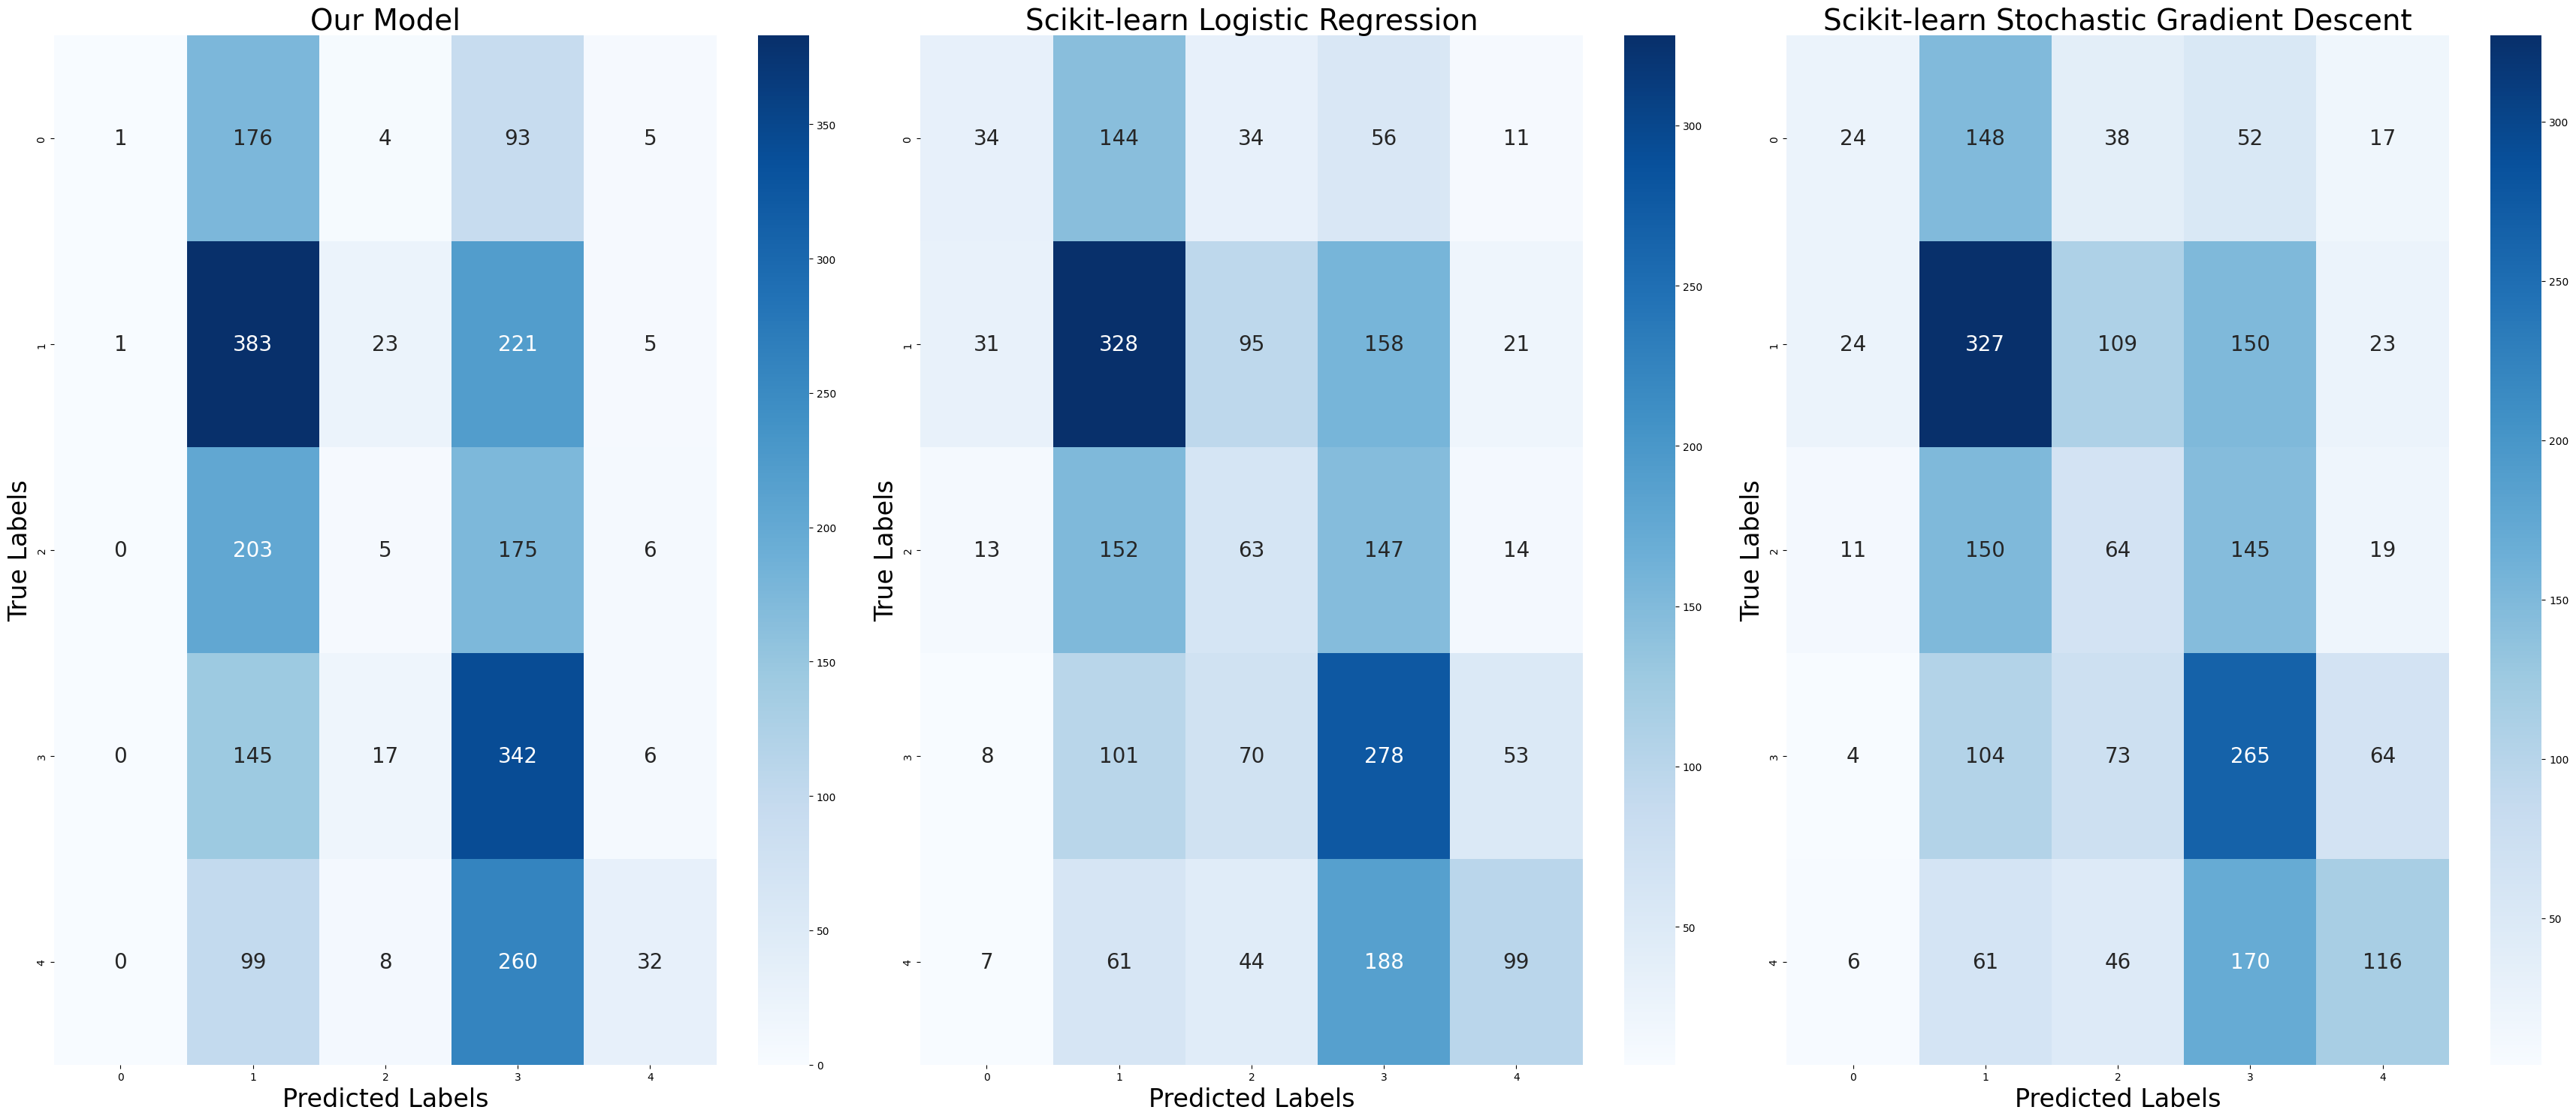

In [31]:
import matplotlib.pyplot as plt
import seaborn as sns

# Declare font size variables for reuse
title_fontsize = 28
label_fontsize = 24
annot_fontsize = 20

# Plot the heatmaps side-by-side
fig, axes = plt.subplots(1, 3, figsize=(35, 15))

# Heatmap for 'Our Model'
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=axes[0], annot_kws={"size": annot_fontsize})
axes[0].set_title('Our Model', fontsize=title_fontsize)
axes[0].set_xlabel("Predicted Labels", fontsize=label_fontsize)
axes[0].set_ylabel("True Labels", fontsize=label_fontsize)

# Heatmap for 'Scikit-learn Logistic Regression'
sns.heatmap(conf_matrix_sk_LR, annot=True, fmt='d', cmap='Blues', ax=axes[1], annot_kws={"size": annot_fontsize})
axes[1].set_title('Scikit-learn Logistic Regression', fontsize=title_fontsize)
axes[1].set_xlabel("Predicted Labels", fontsize=label_fontsize)
axes[1].set_ylabel("True Labels", fontsize=label_fontsize)

# Heatmap for 'Scikit-learn Stochastic Gradient Descent'
sns.heatmap(conf_matrix_sk_SGD, annot=True, fmt='d', cmap='Blues', ax=axes[2], annot_kws={"size": annot_fontsize})
axes[2].set_title('Scikit-learn Stochastic Gradient Descent', fontsize=title_fontsize)
axes[2].set_xlabel("Predicted Labels", fontsize=label_fontsize)
axes[2].set_ylabel("True Labels", fontsize=label_fontsize)

plt.tight_layout()
plt.show()




### Metrics Comparison

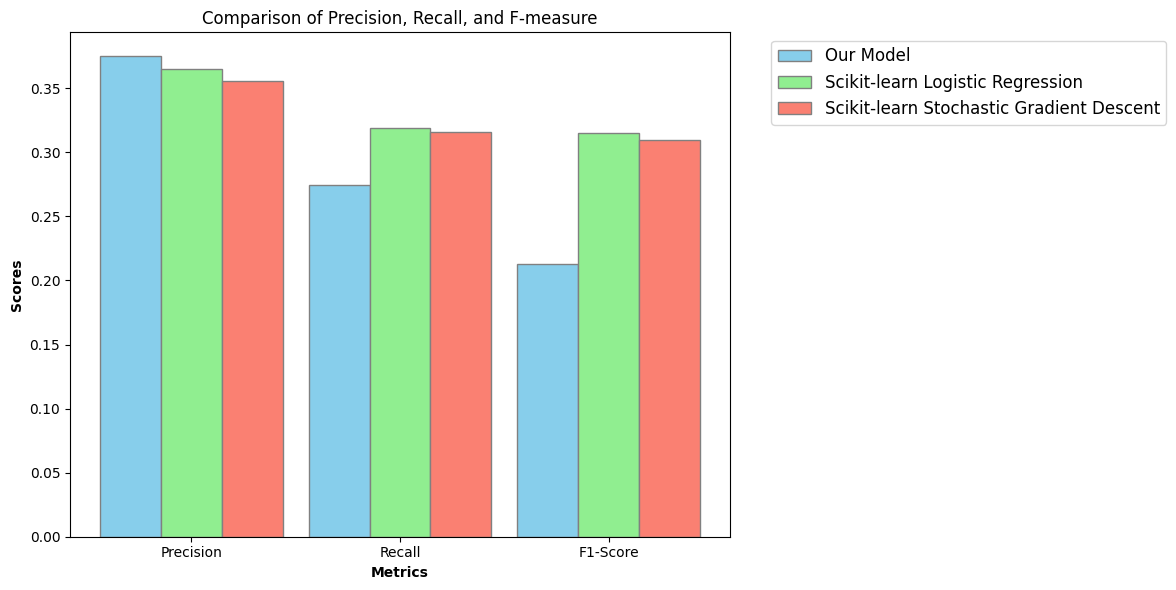

In [32]:
import numpy as np
import matplotlib.pyplot as plt

# Data
comparison_metrics = ['Precision', 'Recall', 'F1-Score']
my_algorithm_scores = [metrics_df.loc[5, 'Precision'], metrics_df.loc[5, 'Recall'], metrics_df.loc[5, 'F1-Score']]
sklearn_LR_scores = [metrics_sk_LR.loc[5, 'Precision'], metrics_sk_LR.loc[5, 'Recall'], metrics_sk_LR.loc[5, 'F1-Score']]
sklearn_SGD_scores = [metrics_sk_SGD.loc[5, 'Precision'], metrics_sk_SGD.loc[5, 'Recall'], metrics_sk_SGD.loc[5, 'F1-Score']]

# Set bar width and gap
bar_width = 0.35
gap = 0.15  # Gap between sets of bars

# Set position of bars on X axis with gap
r1 = np.arange(len(comparison_metrics)) * (3 * bar_width + gap)
r2 = [x + bar_width for x in r1]
r3 = [x + 2 * bar_width for x in r1]

# Increase figure size
plt.figure(figsize=(12, 6))  # Adjust width and height as needed

# Create bars
plt.bar(r1, my_algorithm_scores, color='skyblue', width=bar_width, edgecolor='grey', label='Our Model')
plt.bar(r2, sklearn_LR_scores, color='lightgreen', width=bar_width, edgecolor='grey', label='Scikit-learn Logistic Regression')
plt.bar(r3, sklearn_SGD_scores, color='salmon', width=bar_width, edgecolor='grey', label='Scikit-learn Stochastic Gradient Descent')

# Add labels
plt.xlabel('Metrics', fontweight='bold')
plt.ylabel('Scores', fontweight='bold')
plt.title('Comparison of Precision, Recall, and F-measure')
plt.xticks([r + bar_width for r in r1], comparison_metrics)

# Add legend outside the plot, adjust font size
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1), fontsize=12)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping
plt.show()
